## PHY4268 Tutorial 6 -L'énergie de liaison entre le proton et le neutron dans le noyau Deutéron

1. **S. G. Nana Engo**, serge.nana-engo@facsciences-uy1.cm
    * Department of Physics, Faculty of Science, University of Yaounde I
2. **J-P. Tchapet Njafa**, jean-pierre.tchapet-njafa@univ-maroua.cm
    * Department of Physics, Faculty of Science, University of Maroua
       
May 2024

Dans ce tutoriel, nous allons retrouver les résultats de l'article [[1]](https://arxiv.org/pdf/1801.03897.pdf), où les auteurs calculent de l'énergie de liaison entre le proton et le neutron dans le noyau Deutéron, en utilisant les NISQ ((Noisy Intermediate-Scale Quantum)), c'est-à-dire des processeurs de quelques qubits sujets aux erreurs et au bruit quantique.
 
## Étape 1: Importation des packages dont nous avons besoin pour résoudre le problème

In [1]:
import numpy as np

## Étape 2: définir certaines fonctions que nous utiliserons 

 Avant de commencer la définition du Deuteron Hamiltonien, nous devons définir une fonction d'utilité implémentant le delta de Kronecker, qui est définie comme suit: 

\begin{equation}
\delta_{n, m} = \begin{cases}0 & \text{if } n\neq m, \\ 1 & \text{if } n = m.  \end{cases}
\end{equation}

 Cette fonction apparaît dans la définition Hamiltonienne de Deuteron donnée dans [[1]](https://arxiv.org/pdf/1801.03897.pdf). Ci-dessous, nous avons un morceau de code qui définit la fonction Kronecker Delta.

In [2]:
def kronecker_delta_function(n: int, m: int) -> int:
    """An implementation of the Kronecker delta function.

    Args:
        n (int): The first integer argument.
        m (int): The second integer argument.

    Returns:
        Returns 1 if n = m, else returns 0.
    """
    return int(n == m)

Dans [[1]](https://arxiv.org/pdf/1801.03897.pdf), nous pouvons trouver l'expression suivante pour l'Hamiltonien de Deuteron

\begin{equation}
H_N = \sum_{n,m=0}^{N-1}\langle m|(T+V)|n\rangle a_m^\dagger a_n,
\end{equation}

 où $|n\rangle$ et $|m\rangle$ représentent les états quantiques dans la base de l'oscillateur harmonique, et $a_m^\dagger$ et $a_n$ les opérateurs de création et d'annihilation, respectivement. 

 Pour créer le code qui définit $H_N$, nous avons besoin des éléments matriciels de l'énergie cinétique et potentielle. Encore une fois, nous trouvons ces expressions dans [[1]](https://arxiv.org/pdf/1801.03897.pdf): 

 \begin{align*}
 &\langle m|T|n\rangle = \frac{\hbar\omega}{2}\left[\left(2n+\frac32\right)\delta_{n,m}-\sqrt{n(n+\frac12)}\delta_{n,m+1}-\sqrt{(n+1)(n+\frac32)}\delta_{n,m-1}\right],
&\langle m|V|n\rangle = V_0\delta_{n,0}\delta_{n,m}.
\end{align*}

 $V_0 = -5.68658111 \ \textrm{MeV}$ et $\hbar\omega = 7 \ \textrm{MeV}$. Cependant, l'Hamiltonien écrit de cette manière ne peut pas être traité directement dans un calculateur quantique, car celui-ci  manipule les qubits à travers des portes basées sur les matrices Pauli. Ainsi, nous devons convertir les opérateurs de création et d'annihilation en opérateurs de Pauli. Pour ce faire, nous pouvons utiliser la **transformation de la Jordanie-Wigner**.
 
 Pour construire l'Hamiltonien, initialement, nous utilisons une boucle pour construire et stocker les étiquettes et les coefficients dans un tuple, et après cela, nous ajoutons le tuple dans une liste. Chaque étiquette de chaîne et coefficient définissent un élément cinétique $\langle m|T|n\rangle$ et un élément potentiel $\langle m|V|n\rangle$ du Hamiltonien. À la fin de la boucle `FOR`, nous devons passer la liste avec les tuples avec des étiquettes et des coefficients à `FermionicOp`, afin de créer un Hamiltonien en termes d'opérateurs de création et d'annihilation. Nous devons réécrire ce Hamiltonien en termes d'opérateurs de Pauli, pour ce faire, nous utilisons `JordanWignerMapper()`. 

In [5]:
def create_deuteron_hamiltonian(
    N: int, hbar_omega: float = 7.0, V_0: float = -5.68658111
) :
    """Creates the Deuteron Hamiltonian as a qubit operator.

    Args:
        N (int): An integer number that represents the dimension of the basis.
        hbar_omega (float, optional): The value of the product of hbar and omega. Defaults to 7.0.
        V_0 (float, optional): The value of the potential energy. Defaults to -5.68658111.

    Returns:
        SparsePauliOp: The qubit-space Hamiltonian that represents the Deuteron.
    """
    from qiskit_nature.second_q.operators import FermionicOp
    from qiskit_nature.second_q.mappers import JordanWignerMapper
    from qiskit.quantum_info import Pauli, SparsePauliOp
    
    hamiltonian_terms = {} # Initialization
    for m in range(N):
        for n in range(N):

            label = f"+_{str(n)} -_{str(m)}"
            coefficient_kinect = (hbar_omega / 2) * (
                (2 * n + 3 / 2) * kronecker_delta_function(n, m)
                - np.sqrt(n * (n + (1 / 2))) * kronecker_delta_function(n, m + 1)
                - np.sqrt((n + 1) * (n + (3 / 2)) * kronecker_delta_function(n, m - 1))
            )
            hamiltonian_terms[label] = coefficient_kinect

            coefficient_potential = (
                V_0 * kronecker_delta_function(n, 0) * kronecker_delta_function(n, m)
            )
            hamiltonian_terms[label] += coefficient_potential
    print(f"Construction du Hamiltonien fermionic:\n {hamiltonian_terms}\n")
    hamiltonian = FermionicOp(hamiltonian_terms, num_spin_orbitals=N)
    mapper = JordanWignerMapper()
    qubit_hamiltonian = mapper.map(hamiltonian)
    # if not isinstance(qubit_hamiltonian, SparsePauliOp):
    #     qubit_hamiltonian = qubit_hamiltonian.primitive

    return qubit_hamiltonian

## Étape 3 : Utilisation des outils Qiskit pour calculer l'énergie de liaison entre le proton et le neutron dans le noyau de Deutéron

Nous devons construire un *ansatz* via un **circuit quantique paramétré** et l'utiliser dans le `VQE`  pour calculer la valeur propre minimale de l'Hamiltonien de Deutéron (énergie de liaison).


Nous allons commencer par $H_1$, qui est la forme la plus simple de l'Hamiltonien de Deutéron ($N = 1$). Dans [[1]](https://arxiv.org/pdf/1801.03897.pdf), les auteurs ont calculé l'énergie de l'état fondamental pour $N = 1,2,3$ et ont utilisé ces valeurs pour extrapoler l'énergie et essayez d'atteindre $-2,22 \text{MeV}$, la valeur de l'énergie fondamentale du deuton. Ici, nous allons créer une liste pour stocker les Hamiltoniens $H_1$, $H_2$, $H_3$ et $H_4$, car nous utiliserons ces Hamiltoniens plus tard pour calculer l'état fondamental. Pour ce faire, nous pouvons faire une compréhension de liste avec la fonction `create_deuteron_hamiltonian` que nous avons définie ci-dessus.

In [6]:
deuteron_hamiltonians = [create_deuteron_hamiltonian(i) for i in range(1, 5)]

Construction du Hamiltonien fermionic:
 {'+_0 -_0': -0.43658110999999966}

Construction du Hamiltonien fermionic:
 {'+_0 -_0': -0.43658110999999966, '+_1 -_0': -4.286607049870561, '+_0 -_1': -4.286607049870561, '+_1 -_1': 12.25}

Construction du Hamiltonien fermionic:
 {'+_0 -_0': -0.43658110999999966, '+_1 -_0': -4.286607049870561, '+_2 -_0': 0.0, '+_0 -_1': -4.286607049870561, '+_1 -_1': 12.25, '+_2 -_1': -7.826237921249264, '+_0 -_2': 0.0, '+_1 -_2': -7.826237921249264, '+_2 -_2': 19.25}

Construction du Hamiltonien fermionic:
 {'+_0 -_0': -0.43658110999999966, '+_1 -_0': -4.286607049870561, '+_2 -_0': 0.0, '+_3 -_0': 0.0, '+_0 -_1': -4.286607049870561, '+_1 -_1': 12.25, '+_2 -_1': -7.826237921249264, '+_3 -_1': 0.0, '+_0 -_2': 0.0, '+_1 -_2': -7.826237921249264, '+_2 -_2': 19.25, '+_3 -_2': -11.341296222213757, '+_0 -_3': 0.0, '+_1 -_3': 0.0, '+_2 -_3': -11.341296222213757, '+_3 -_3': 26.25}



In [10]:
from qiskit_nature.second_q.operators import FermionicOp
FermionicOp({'+_0 -_0': -0.43658110999999966, '+_1 -_0': -4.286607049870561, '+_0 -_1': -4.286607049870561, '+_1 -_1': 12.25}, num_spin_orbitals=2)

FermionicOp({'+_0 -_0': -0.43658110999999966, '+_1 -_0': -4.286607049870561, '+_0 -_1': -4.286607049870561, '+_1 -_1': 12.25}, num_spin_orbitals=2, )

In [8]:
deuteron_hamiltonians[1]

SparsePauliOp(['II', 'IZ', 'XX', 'YY', 'ZI'],
              coeffs=[ 5.90670945+0.j,  0.21829055+0.j, -2.14330352+0.j, -2.14330352+0.j,
 -6.125     +0.j])

En référence [[1]](https://arxiv.org/pdf/1801.03897.pdf), nous pouvons trouver les expressions exactes pour l'Hamiltonien du Deutéron de la taille N = 1, 2 et 3 :
$$
\begin{split}
H_1 &= 0.218291(Z_0-I_0),\\
H_2 &= 5.906709I_1\otimes I_0 + 0.218291I_1\otimes Z_0 - 6.215Z_1\otimes I_0 - 2.143304(X_1\otimes X_0 + Y_1 \otimes Y_0),\\
H_3 &= I_2\otimes H_2 + 9.625(I_2\otimes I_1\otimes I_0 - Z_2\otimes I_1\otimes I_0) - 3.913119(X_2\otimes X_1\otimes I_0 + Y_2\otimes Y_1\otimes I_0).\end{split}$$

Nous pouvons vérifier que notre fonction `create_deuteron_hamiltonian` donne les mêmes résultats.  

In [11]:
for i, hamiltonian in enumerate(deuteron_hamiltonians):
    print(f"Deuteron Hamiltonian H_{i+1} :")
    print(hamiltonian)
    print("\n")

Deuteron Hamiltonian H_1 :
SparsePauliOp(['I', 'Z'],
              coeffs=[-0.21829055+0.j,  0.21829055+0.j])


Deuteron Hamiltonian H_2 :
SparsePauliOp(['II', 'IZ', 'XX', 'YY', 'ZI'],
              coeffs=[ 5.90670945+0.j,  0.21829055+0.j, -2.14330352+0.j, -2.14330352+0.j,
 -6.125     +0.j])


Deuteron Hamiltonian H_3 :
SparsePauliOp(['III', 'IIZ', 'IXX', 'IYY', 'IZI', 'XXI', 'YYI', 'ZII'],
              coeffs=[15.53170945+0.j,  0.21829055+0.j, -2.14330352+0.j, -2.14330352+0.j,
 -6.125     +0.j, -3.91311896+0.j, -3.91311896+0.j, -9.625     +0.j])


Deuteron Hamiltonian H_4 :
SparsePauliOp(['IIII', 'IIIZ', 'IIXX', 'IIYY', 'IIZI', 'IXXI', 'IYYI', 'IZII', 'XXII', 'YYII', 'ZIII'],
              coeffs=[ 28.65670945+0.j,   0.21829055+0.j,  -2.14330352+0.j,  -2.14330352+0.j,
  -6.125     +0.j,  -3.91311896+0.j,  -3.91311896+0.j,  -9.625     +0.j,
  -5.67064811+0.j,  -5.67064811+0.j, -13.125     +0.j])




Nous pouvons voir que notre fonction nous donne le bon résultat pour $H_1$, $H_2$ et $H_3$. Cependant, nous n'avons pas d'expression pour $H_4$ dans [[1]](https://arxiv.org/pdf/1801.03897.pdf), mais il est possible de dire, par récurrence, que le résultat est correct.

Comme dans dans [[1]](https://arxiv.org/pdf/1801.03897.pdf), nous allons travailler avec des *ansatze* de faible profondeur, puisque les circuits quantiques de faible profondeur permettent d'obtenir de bons résultats sans qu'aucune correction d'erreur quantique ne soit implémentée (NISQ). A cet effet, nous devons définir deux paramètres pour construire les circuits présentés dans [[1]](https://arxiv.org/pdf/1801.03897.pdf), $\theta$ (theta) et $\eta$ (eta), et nous pouvons le faire en utilisant `Parameter()` comme indiqué dans le code de cellule ci-dessous.

In [12]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter(r"$\theta$")
eta = Parameter(r"$\eta$")

En utilisant les paramètres définis ci-dessus et en suivant les instructions pour construire les circuits présentés dans [[1]](https://arxiv.org/pdf/1801.03897.pdf), nous obtenons les circuits suivants:

/home/tchapet/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


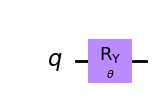

In [13]:
wavefunction = QuantumCircuit(1)
wavefunction.ry(theta, 0)
wavefunction.draw("mpl")

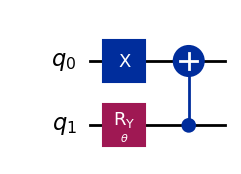

In [17]:
wavefunction2 = QuantumCircuit(2)
wavefunction2.x(0)
wavefunction2.ry(theta, 1)
wavefunction2.cx(1, 0)
wavefunction2.draw(style="iqp")

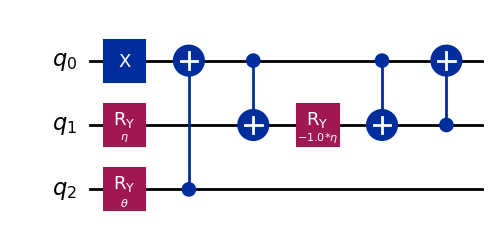

In [15]:
wavefunction3 = QuantumCircuit(3)
wavefunction3.x(0)
wavefunction3.ry(eta, 1)
wavefunction3.ry(theta, 2)
wavefunction3.cx(2, 0)
wavefunction3.cx(0, 1)
wavefunction3.ry(-eta, 1)
wavefunction3.cx(0, 1)
wavefunction3.cx(1, 0)
wavefunction3.draw(style="iqp")

Comme, dans [[1]](https://arxiv.org/pdf/1801.03897.pdf), nous ne trouvons pas de circuit de faible profondeur pour l'*ansatz* pour $H_4$, pour l'instant nous n'allons pas travailler avec $N = 4$, mais plus tard nous reviendrons sur ce problème en utilisant `TwoLocal` comme *ansatz* (*ansatz* de type **HEA**).

Nous pouvons stocker ces circuits dans la liste ansatz pour effectuer des tests.

In [18]:
ansatz = [wavefunction, wavefunction2, wavefunction3]

La taille plutôt petite de nos opérateurs générés nous permet d'utiliser un solveur classique pour obtenir l'énergie de liaison pour $H_1$, $H_2$, $H_3$ et $H_4$.

In [19]:
from qiskit_algorithms import NumPyMinimumEigensolver

ref_values = []
print("Exact binding energies calculated through Numpy \n")
for i, H in enumerate(deuteron_hamiltonians):
    exact_result = NumPyMinimumEigensolver().compute_minimum_eigenvalue(H)
    print(f'Exact binding energy for H_{i+1} is: {exact_result.eigenvalue.real} Mev')
    ref_values.append(exact_result.eigenvalue)

Exact binding energies calculated through Numpy 

Exact binding energy for H_1 is: -0.43658110999999966 Mev
Exact binding energy for H_2 is: -1.74915987632153 Mev
Exact binding energy for H_3 is: -2.0456708984064473 Mev
Exact binding energy for H_4 is: -2.1439810307998726 Mev


Les résultats obtenus ci-dessus seront utilisés comme valeurs de référence. Ainsi, nous pouvons les utiliser pour voir si l'algorithme `VQE` nous donne de bons résultats. Dans la cellule de code ci-dessous, nous avons exécuté l'algorithme `VQE` pour chaque paire *ansatz* (fonction d'état d'essai) et Hamiltonien, en utilisant l'estimateur `Estimator` et l'optimiseur `SLSQP`.

In [20]:
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import SLSQP
from qiskit_algorithms import VQE

print(
    "Results using Estimator for H_i(i=1-3) with the ansatz given in the reference paper \n"
)
for i in range(3):
    vqe_solver = VQE(Estimator(), ansatz[i], SLSQP())
    vqe_solver.initial_point = None # Initialisation with zero-qubit

    # VQE results 
    vqe_result = vqe_solver.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    binding_energy = vqe_result.optimal_value
    print(f"Binding energy for H_{i+1}: {binding_energy} MeV")

Results using Estimator for H_i(i=1-3) with the ansatz given in the reference paper 

Binding energy for H_1: -0.4365810897012178 MeV
Binding energy for H_2: -1.749159874068185 MeV
Binding energy for H_3: -2.045670886484988 MeV


Nous constatons que nos résultats sont en accord avec les valeurs de référence obtenues avec Numpy. 

Nous pouvons également tester différentes options d'optimiseurs fournis dans Qiskit, afin voir lequel se comporte le mieux. Pour ce faire, nous utilisons l'option `callback` dans `VQE` pour stocker la liste des comptes et des valeurs. Avec ces informations, il est possible de réaliser un tracé pour voir si l'optimiseur converge vers la valeur de référence et, s'il converge, à quelle vitesse il le fait. Cependant, dans la cellule de code ci-dessous, nous travaillons uniquement avec l'optimiseur `COBYLA` par souci de simplicité.

In [21]:
def callback(eval_count, parameters, mean, std):
    from IPython.display import display, clear_output

    # Overwrites the same line when printing
    display(f"Evaluation: {eval_count}, Energy: {mean}, Std: {std}")
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

In [22]:
from qiskit_algorithms.optimizers import COBYLA

plots = []

for i in range(3):
    counts = []
    values = []
    params = []
    deviation = []
    vqe = VQE(Estimator(), ansatz=ansatz[i], optimizer=COBYLA(), callback=callback)
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    plots.append([counts, values])

'Evaluation: 41, Energy: -2.0456706541100456, Std: {}'

* Tracer des résultats `VQE` précédents.

/home/tchapet/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


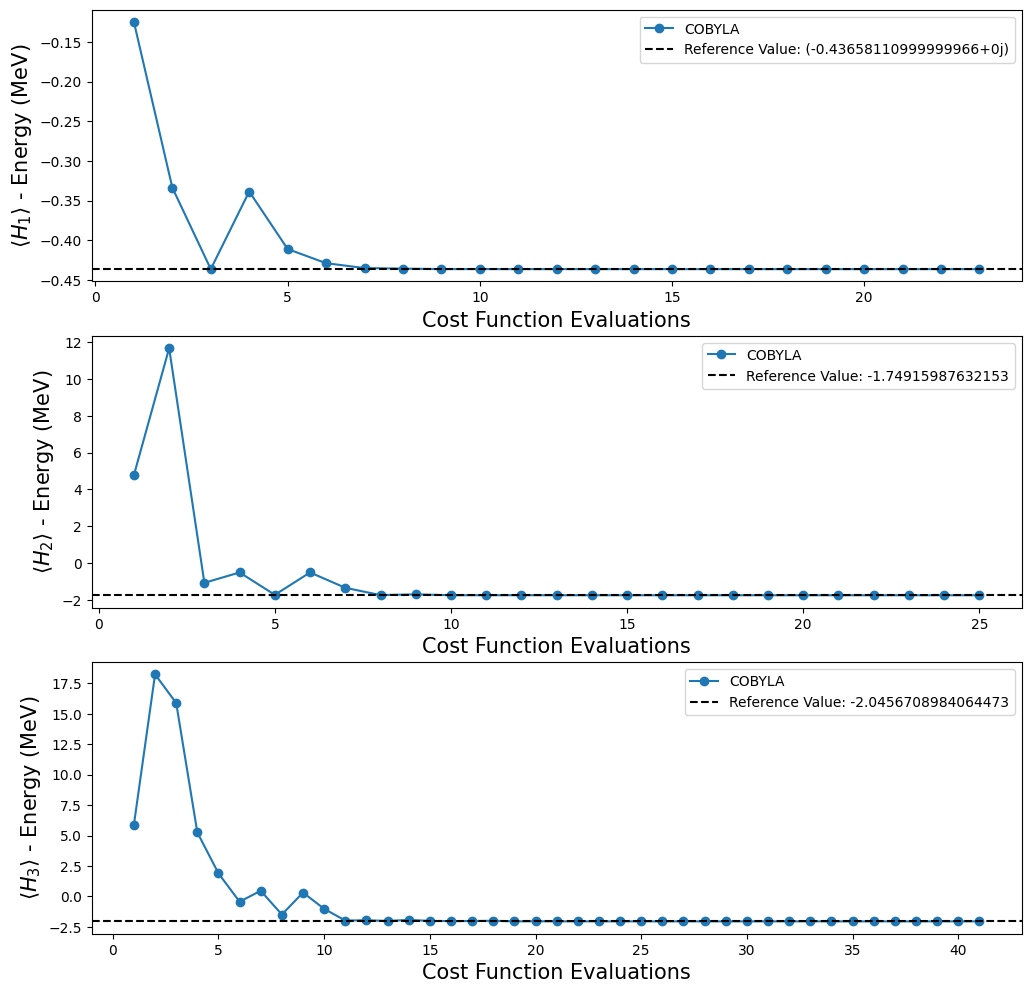

In [23]:
# Plotting  of previous VQE results
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches((12, 12))
for i, plot in enumerate(plots):
    ax[i].plot(plot[0], plot[1], "o-", label="COBYLA")
    ax[i].axhline(
        y=ref_values[i],
        color="k",
        linestyle="--",
        label=f"Reference Value: {ref_values[i]}",
    )
    ax[i].legend()
    ax[i].set_xlabel("Cost Function Evaluations", fontsize=15)
    ax[i].set_ylabel(r"$\langle H_{} \rangle$ - Energy (MeV)".format(i + 1), fontsize=15)
plt.show()

Pour tester $H_4$, nous allons la fonction `qiskit.circuit.library.TwoLocal` pour construire notre nouveau `ansatz`. Dans la cellule de code ci-dessous, nous avons utilisé une boucle for pour créer une liste avec l'*ansatz* `TwoLocal` pour chaque Hamiltonien.

In [24]:
from qiskit.circuit.library import TwoLocal

twolocal_ansatzes = []
for i in range(1, 5):
    ansatz = TwoLocal(
        deuteron_hamiltonians[i - 1].num_qubits,
        ["rz", "ry"],
        "cx",
        entanglement="full",
        reps=i,
        initial_state=None,
    )
    twolocal_ansatzes.append(ansatz)

Vérifions qu'avec ce nouveau type d'*ansatz*, nous pouvons obtenir les valeurs de référence Numpy.

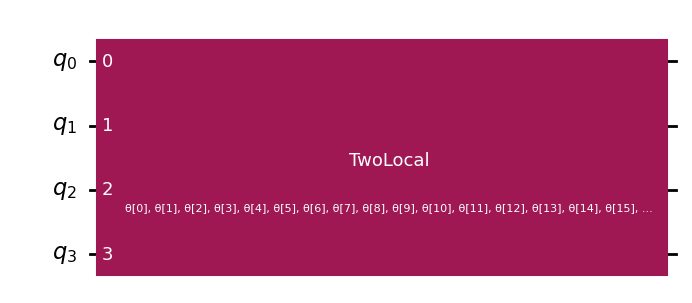

In [29]:
twolocal_ansatzes[3].draw(style="iqp")

In [30]:
print("Results using Estimator for H_i(i=1-4) with TwoLocal ansatz \n")
# seed = 42
# algorithm_globals.random_seed = seed
for i in range(4):
    vqe = VQE(Estimator(), ansatz=twolocal_ansatzes[i], optimizer=SLSQP())

    # VQE results 
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    binding_energy = vqe_result.optimal_value
    print(f"Binding energy for H_{i+1}: {binding_energy} MeV")

Results using Estimator for H_i(i=1-4) with TwoLocal ansatz 

Binding energy for H_1: -0.43658109487943386 MeV
Binding energy for H_2: -1.7491598591506294 MeV
Binding energy for H_3: -2.0456708595019375 MeV
Binding energy for H_4: -2.1439538021534954 MeV


In [32]:
plots_tl = []
for i in range(4):

    counts = []
    values = []
    params = []
    deviation = []
    vqe = VQE(
        Estimator(),
        ansatz=twolocal_ansatzes[i],
        optimizer=COBYLA(),
        callback=callback,
    )
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    plots_tl.append([counts, values])

'Evaluation: 1000, Energy: -2.0711144895558977, Std: {}'

En utilisant les quatre différents *ansatze* `TwoLocal`, nous obtenons les résultats suivants avec l'optimiseur `COBYLA`:

/home/tchapet/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


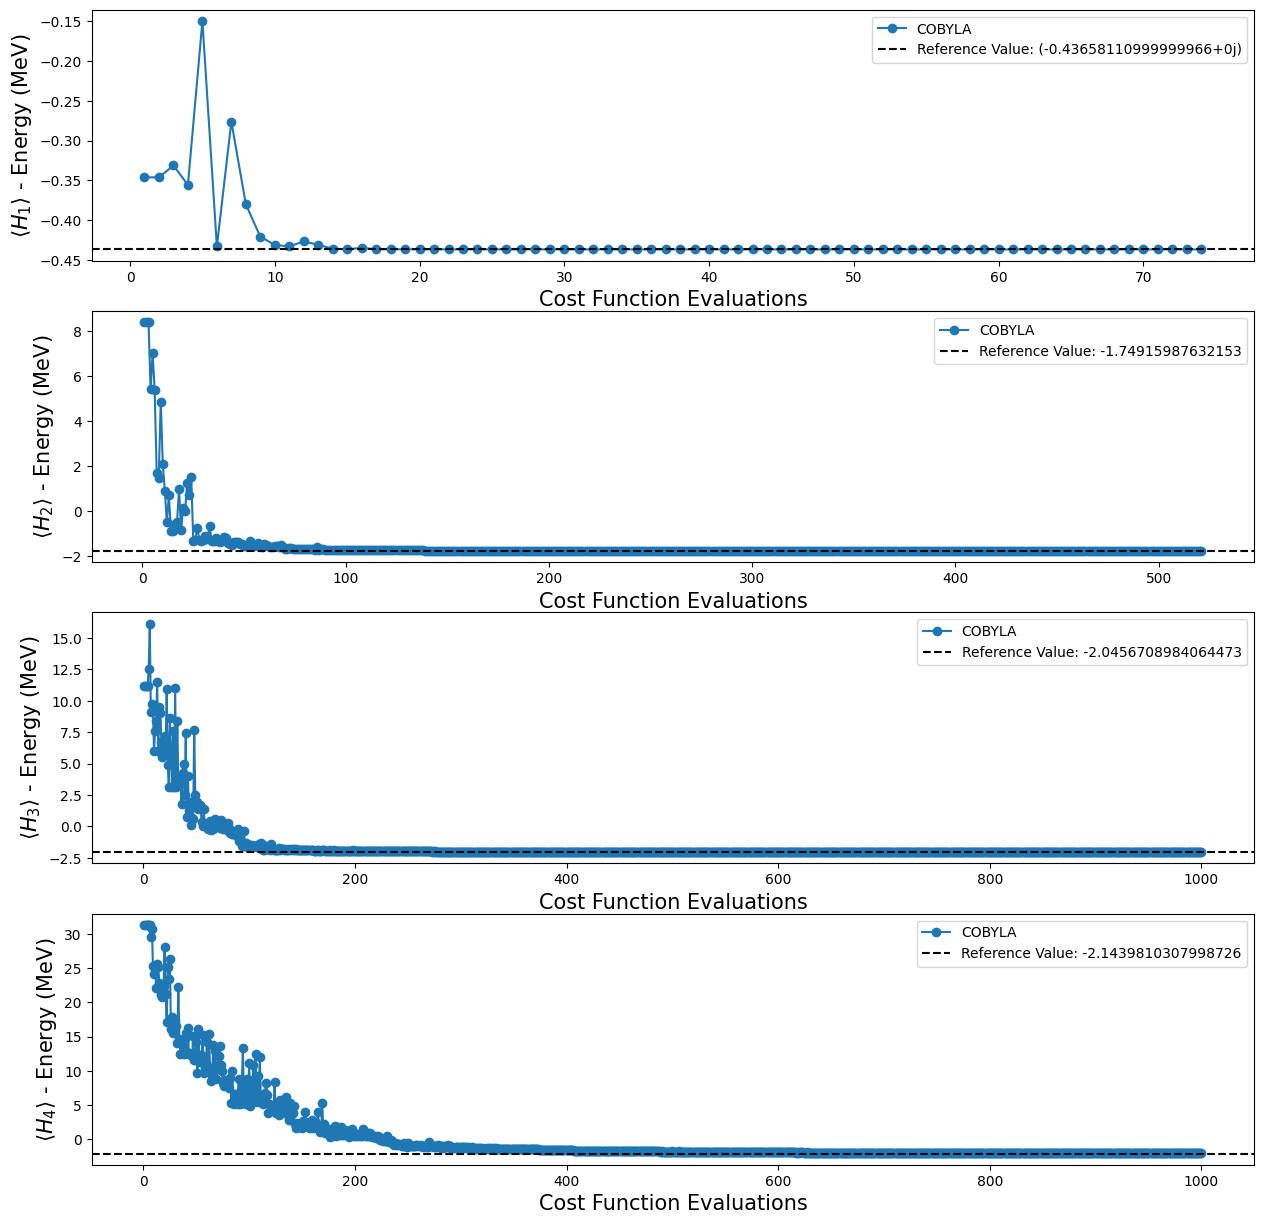

In [33]:
fig, ax = plt.subplots(nrows=4, ncols=1)
fig.set_size_inches((15, 15))
for i, plot in enumerate(plots_tl):
    ax[i].plot(plot[0], plot[1], "o-", label="COBYLA")
    ax[i].axhline(
        y=ref_values[i],
        color="k",
        linestyle="--",
        label=f"Reference Value: {ref_values[i]}",
    )
    ax[i].legend()
    ax[i].set_xlabel("Cost Function Evaluations", fontsize=15)
    ax[i].set_ylabel(r"$\langle H_{} \rangle$ - Energy (MeV)".format(i + 1), fontsize=15)
plt.show()

## Étape 4 : Calcul des valeurs moyennes des propriétés physiques

L'un des objectifs de ce tutoriel est de montrer qu'il est possible de calculer les valeurs moyennes de certains propriétés physiques d'intérêt, et de montrer comment ils se comportent lorsque nous faisons varier un paramètre dans le circuit *ansatz*"*. ici, les propriétés physiques d'intérêt étaient $I_1 \otimes Z_0$, $Z_1 \otimes I_0$, $X_1 \otimes X_0$, $Y_1 \otimes Y_0$ et $H_2$, et nous nous intéressons à leur comportement lorsque le paramètre $\theta$ varit dans l'intervalle $[-\pi,\pi]$.

Le code ci-dessous définit une fonction qui calcule les valeurs d'espérance des propriétés physiques, en utilisant un circuit quantique paramétré et une liste de valeurs pour ces paramètres (angles).

In [ ]:
def calculate_observables_exp_values(
    quantum_circuit: QuantumCircuit, observables: list, angles: list
) -> list:
    """Calculate the expectation value of an observable given the quantum
    circuit that represents the wavefunction and a list of parameters.

        Args:
            quantum_circuit (QuantumCircuit): A parameterized quantum circuit
            that represents the wavefunction of the system.

            observables (list): A list containing the observables that we want
            to know the expectation values.

            angles (list): A list with the values that will be used in the
            'assign_parameters' method.

        Returns:
            list_exp_values (list): A list containing the expectation values
            of the observables given as input.
    """
    from qiskit_algorithms.observables_evaluator import estimate_observables

    list_exp_values = []
    for observable in observables:
        exp_values = []
        for angle in angles:
            qc = quantum_circuit.assign_parameters({theta: angle})
            result = estimate_observables(
                Estimator(),
                quantum_state=qc,
                observables=[observable],
            )

            exp_values.append(result[0][0])
        list_exp_values.append(exp_values)

    return list_exp_values

Calcul de la valeur espémoyennes.

In [ ]:
from qiskit.quantum_info import Pauli

angles = list(np.linspace(-np.pi, np.pi, 100))
observables = [
    Pauli("IZ"),
    Pauli("ZI"),
    Pauli("XX"),
    Pauli("YY"),
    deuteron_hamiltonians[1],
]
h2_observables_exp_values = calculate_observables_exp_values(wavefunction2, observables, angles)

Using the function `calculate_observables_exp_values` (we defined it in the Step 2), we got the plots presented below. They showed us that we were able to reproduce the results of [[1]](https://arxiv.org/pdf/1801.03897.pdf).

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches((12, 12))
ax[0].plot(angles, h2_observables_exp_values[0], "o", label=r"$Z_0$")
ax[0].plot(angles, h2_observables_exp_values[1], "o", label=r"$Z_1$")
ax[0].plot(angles, h2_observables_exp_values[2], "o", label=r"$X_0X_1$")
ax[0].plot(angles, h2_observables_exp_values[3], "o", label=r"$Y_0Y_1$")
ax[0].axhline(
    y=1,
    color="k",
    linestyle="--",
)
ax[0].axhline(y=-1, color="k", linestyle="--")
ax[0].legend()
ax[0].set_xlabel(r"Theta - $\theta$", fontsize=15)
ax[0].set_ylabel(r"$\langle O \rangle $ - Operator Expectation Value", fontsize=15)
ax[0].set_xticks(
    [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi],
    labels=[r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"],
)
ax[0].set_title(
    r"Expectation value of the observables $Z_0$, $Z_1$, $X_0X_1$ and $Y_0Y_1$ when we vary $\theta$ in the ansatz.",
    fontsize=15,
)
ax[1].plot(angles, h2_observables_exp_values[4], "o")
ax[1].axhline(
    y=ref_values[1],
    color="k",
    linestyle="--",
    #label="Binding Energy: {} MeV".format(np.round(ref_values[1], 3)),
    label=f"Binding Energy: {np.round(ref_values[1], 3)} MeV",
)
ax[1].legend()
ax[1].set_xlabel(r"Theta - $\theta$", fontsize=15)
ax[1].set_ylabel(r"$\langle H_2 \rangle $ - Energy (MeV)", fontsize=15)
ax[1].set_xticks(
    [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi],
    labels=[r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"],
)
ax[1].set_title(
    r"Behavior of the expectation value of $H_2$ when we vary $\theta$ in the ansatz.", fontsize=15
)

plt.show()

## References

[1] Dumitrescu, Eugene F., et al. *Cloud quantum computing of an atomic nucleus*, Physical review letters **120.21** (2018): 210501. Arxiv version: https://arxiv.org/pdf/1801.03897.pdf
